# MNIST-MINI, Extended Results

This notebook has the following structure:

1. Loads the log file from the 16x16 MNIST extended experiments
2. Describes the experiment and explores experiment data and metadata
3. Reports comparison between parameter magnitude masks and random masks in terms of their overlap, showing that:
  * parameter magnitude masks have substantially larger overlap than random
  * overlap of randomly drawn masks aligns roughly with the analytical baseline

In [1]:
import collections
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from tueplots import bundles, figsizes

In [2]:
# setup and globals
sns.set_theme(style="white")
colors = sns.color_palette()

# Load Experiment Data

In [3]:
def read_file(
    path,
    body_fn=lambda x: x,
    filter_headers=None,
    ts_colname="TIMESTAMP",
    header_colname="HEADER",
):
    """
    Load a log file into a pandas table. The file is assumed to be created
    by repeatedly calling the ``loj`` method, hence having lines in the
    form ``[timestamp, [header, body]]``.

    :param filter_headers: Collection of allowed headers. If given, only
      entries with these headers will be gathered.
    :param body_fn: The ``body`` entry from each line will be passed to
      this function for processing. The function must return a dictionary,
      such that all the returned key-value pairs will be aggregated into
      the output pandas table. If the body is already in the form of a
      dictionary, and you want to preserve all key-value pairs, this
      function is simply the identity. It can be used to filter out
      entries, rename keys, etc.
    :returns: A pandas dataframe, with ``ts_colname, header_colname``
      columns, as well as one column per key returned by ``body_fn``.
    """
    # first gather a list of [timestamp, [header, body]] entries
    entries = pd.read_json(path, lines=True).values.tolist()
    result = []
    for i, (ts, (header, body)) in enumerate(entries):
        if (filter_headers is not None) and (header not in filter_headers):
            continue
        body = body_fn(body)
        assert (ts_colname not in body) and (
            header_colname not in body
        ), "Colliding timestamp/header column names! {body.keys()}"
        try:
            result.append({ts_colname: ts, header_colname: header, **body})
        except TypeError:
            breakpoint()
            pass
    #
    result = pd.DataFrame(result)
    return result


def parse_log_hess(
    log_hess,
    step,
    fields={
        "core_S",
        "info",
        "Frob(H)^2",
        "Frob(H_355)^2",
        "Frob(H_178)^2",
        "Frob(H_18)^2",
        "Frob(H-H_355)^2",
        "Frob(H-H_178)^2",
        "Frob(H-H_18)^2",
        "P(err<=0.75x)",
        "P(err>=1.25x)",
        "P(err<=0.5x)",
        "P(err>=1.5x)",
        "P(err<=0x)",
        "P(err>=2x)",
        "scree_lower",
        "scree_upper",
        "frob_Qtop^2_mag",
        "frob_Qtop^2_best",
        "frob_Qtop^2_rand",
        "largest_absparams",
        "best_overlap_params",
    },
):
    """ """
    result = {}
    for field in fields:
        vals = log_hess[log_hess["step"] == step][field]
        vals = vals[vals.notnull()]
        try:
            vals = vals.item()
        except ValueError:
            pass
        result[field] = vals
    return result

In [4]:
LOG_PATH = "2024_03_27_04_35_53.077[20b_mnist_mini_random_masks.py].log"
#
log_conf = read_file(LOG_PATH, filter_headers={"CONFIG"})
log_glob = read_file(LOG_PATH, filter_headers={"GLOBALS"})
log_batch = read_file(LOG_PATH, filter_headers={"TRAINING BATCH"})
log_eval = read_file(LOG_PATH, filter_headers={"EVAL ROUND", "FINAL EVALUATION"})
log_test_hess = read_file(LOG_PATH, filter_headers={"H_TEST RESULT"})
log_train_hess = read_file(LOG_PATH, filter_headers={"H_TRAIN RESULT"})
#
num_params = int(log_glob["num_params"][0])
record_steps = log_glob["record_steps"].item()
test_hess_data = [parse_log_hess(log_test_hess, step) for step in record_steps]
train_hess_data = [parse_log_hess(log_train_hess, step) for step in record_steps]

# Experiment Summary:

* Trained 7030-parameter MLP on downsampled MNIST digit classification
* Trained for 1000 steps reaching 95.78% accuracy
* Every 100 steps, computed sketched (train/test) Hessian eigendecomposition using 50 samples per class (500 total) and 355 eigenpairs (5% of total)
* Logged several quantities of interest:
  * obtained eigenspectra
  * quality of recovery
  * overlap for parameter magnitude masks, best-overlap masks, and random masks

Below is an overview of the data:

In [5]:
log_conf

,TIMESTAMP,HEADER,OBS_DATASETS,TUNING_CONF,OPTIMIZER,PROBLEM,RANDOM_SEED,MAX_STEPS,DEVICE,OUTPUT_DIR,OUTDIR_SUFFIX,RECORD_STEPS,NUM_HESSIAN_DATAPOINTS,WITH_TEST_HESSIAN,WITH_TRAIN_HESSIAN,NUM_OUTER,NUM_INNER,WITH_A_POSTERIORI,NUM_A_POSTERIORI,NUM_RAND_MASKS
0,2024-03-27_04:35:53.080,CONFIG,REDACTED/datasets/DeepOBS,config/basic_config.yaml,SGD,mnist_mini,12345,16001,cuda,output,20b,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...",500,True,True,355,710,True,30,10


In [6]:

log_glob

,TIMESTAMP,HEADER,run_dir,batch_size,num_epochs,max_steps,steps_per_epoch,opt_name,opt_hpars,sched_name,sched_hpars,param_shapes,num_params,H_train_idxs,H_test_idxs,record_steps
0,2024-03-27_04:35:57.007,GLOBALS,output/2024_03_27_04_35_53.076__mnist_mini__12...,500,50,16001,100,SGD,{'lr': 0.30000000000000004},None,None,"[[20, 256], [20], [20, 20], [20], [20, 20], [2...",7030,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 100, 200, 300, 400, 500, 600, 700, 800, 90..."


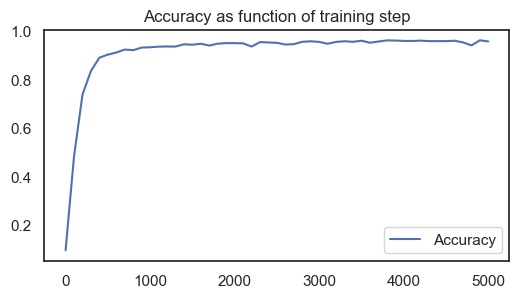

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(log_eval["global_step"], log_eval["test_acc"], label="Accuracy")
ax.legend()
_ = ax.set_title("Accuracy as function of training step")

# Comparing overlap of magnitude masks with random masks

Once the top Hessian eigenbasis is obtained (in the form of a tall matrix), a submatrix $V$ can be obtained by picking $k$ rows will correspond to a parameter mask (since each row corresponds to one parameter). Then, the `overlap` metric can be computed as $\frac{\lVert V \rVert_F^2}{k}$.

In the paper, we computed `overlap` for parameter masks obtained from the $k$-largest parameter magnitudes.
For this extended experiment, we further sampled random columns of $k$ elements, corresponding to random masks, in order to obtain an empirical baseline for overlap.

Comparative results are plotted below. This experiment reinforces the results already reported:

* It can still be observed that magnitude masks yield an overlap that is substantially larger than random
* This random baseline aligns closely with the analytical baseline presented in the paper

In [8]:
def get_overlaps(step_idx, hess_data):
    """
    """
    k_range = np.arange(len(hess_data[step_idx]["frob_Qtop^2_mag"])) + 1
    analytical_baseline = k_range / num_params
    mag_overlap = np.array(hess_data[step_idx]["frob_Qtop^2_mag"]) / k_range
    best_overlap = np.array(hess_data[step_idx]["frob_Qtop^2_best"]) / k_range
    rand_overlaps = np.array(hess_data[step_idx]["frob_Qtop^2_rand"]) / k_range
    #
    rand_mean = rand_overlaps.mean(axis=0)
    rand_std = rand_overlaps.std(axis=0)
    #
    return mag_overlap, best_overlap, (rand_mean, rand_std)

mag_train0, best_train0, (rm_train0, rsdt_train0) = get_overlaps(0, train_hess_data)
mag_train100, best_train100, (rm_train100, rsdt_train100) = get_overlaps(1, train_hess_data)
mag_train1000, best_train1000, (rm_train1000, rsdt_train1000) = get_overlaps(-1, train_hess_data)
#
mag_test0, best_test0, (rm_test0, rsdt_test0) = get_overlaps(0, test_hess_data)
mag_test100, best_test100, (rm_test100, rsdt_test100) = get_overlaps(1, test_hess_data)
mag_test1000, best_test1000, (rm_test1000, rsdt_test1000) = get_overlaps(-1, test_hess_data)

# shared by everyone
analytical_baseline = np.arange(len(mag_train0)) / num_params

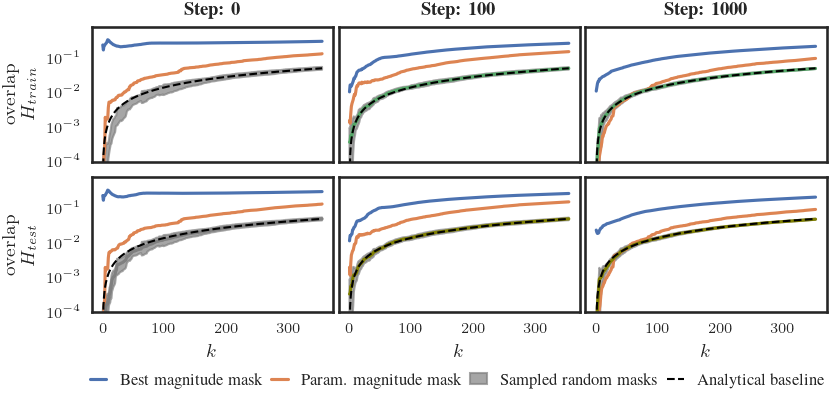

In [9]:
ncols = 3
nrows = 2
hw_ratio = 2 / 3

# TUEplots
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(
    figsizes.neurips2022(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=hw_ratio,
    ),
)
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.025})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.0025})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})


rm_color, rm_alpha = "grey", 0.7
baseline_thick = 1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True)
#
axs[0, 0].plot(best_train0, label="Best magnitude mask")
axs[0, 0].plot(mag_train0, label="Param. magnitude mask")
axs[0, 0].fill_between(list(range(len(rm_train0))), rm_train0-rsdt_train0, rm_train0+rsdt_train0, color=rm_color, alpha=rm_alpha, label="Sampled random masks")
axs[0, 0].plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline", linewidth=baseline_thick)
# axs[0, 0].plot(rm_train0, color="gray", label="Sampled random masks", alpha=1)
axs[0, 0].set_yscale("log")
#
axs[0, 1].plot(best_train100, label="Best magnitude mask")
axs[0, 1].plot(mag_train100, label="Param. magnitude mask")
axs[0, 1].plot(rm_train100, label="Sampled random masks")
axs[0, 1].fill_between(list(range(len(rm_train100))), rm_train100-rsdt_train100, rm_train100+rsdt_train100, color=rm_color, alpha=rm_alpha)
axs[0, 1].plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline", linewidth=baseline_thick)
axs[0, 1].set_yscale("log")
#
axs[0, 2].plot(best_train1000, label="Best magnitude mask")
axs[0, 2].plot(mag_train1000, label="Param. magnitude mask")
axs[0, 2].plot(rm_train1000, label="Sampled random masks")
axs[0, 2].fill_between(list(range(len(rm_train1000))), rm_train1000-rsdt_train1000, rm_train1000+rsdt_train1000, color=rm_color, alpha=rm_alpha)
axs[0, 2].plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline", linewidth=baseline_thick)
axs[0, 2].set_yscale("log")
#
axs[1, 0].plot(best_test0, label="Best magnitude mask")
axs[1, 0].plot(mag_test0, label="Param. magnitude mask")
axs[1, 0].plot(rm_test0, color="gray", label="Sampled random masks")
axs[1, 0].fill_between(list(range(len(rm_test0))), rm_test0-rsdt_test0, rm_test0+rsdt_test0, color=rm_color, alpha=rm_alpha)
axs[1, 0].plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline", linewidth=baseline_thick)
axs[1, 0].set_yscale("log")
#
axs[1, 1].plot(best_test100, label="Best magnitude mask")
axs[1, 1].plot(mag_test100, label="Param. magnitude mask")
axs[1, 1].plot(rm_test100, color="olive", label="Sampled random masks")
axs[1, 1].fill_between(list(range(len(rm_test100))), rm_test100-rsdt_test100, rm_test100+rsdt_test100, color=rm_color, alpha=rm_alpha)
axs[1, 1].plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline", linewidth=baseline_thick)
axs[1, 1].set_yscale("log")
#
axs[1, 2].plot(best_test1000, label="Best magnitude mask")
axs[1, 2].plot(mag_test1000, label="Param. magnitude mask")
axs[1, 2].plot(rm_test1000, color="olive", label="Sampled random masks")
axs[1, 2].fill_between(list(range(len(rm_test1000))), rm_test1000-rsdt_test1000, rm_test1000+rsdt_test1000, color=rm_color, alpha=rm_alpha)
axs[1, 2].plot(analytical_baseline, color="black", linestyle="--", alpha=1, label="Analytical baseline", linewidth=baseline_thick)
axs[1, 2].set_yscale("log")



# axs[0, 0].legend()
#
axs[0, 0].set_title(r"\textbf{Step: 0}")
axs[0, 1].set_title(r"\textbf{Step: 100}")
axs[0, 2].set_title(r"\textbf{Step: 1000}")
#
axs[0, 0].set_ylabel(r"$\mathrm{overlap}$" "\n" "$H_{train}$")
axs[1, 0].set_ylabel(r"$\mathrm{overlap}$" "\n" "$H_{test}$")
#
axs[1, 0].set_xlabel("$k$")
axs[1, 1].set_xlabel("$k$")
axs[1, 2].set_xlabel("$k$")
#
axs[0, 0].set_ylim(1e-4, None)
#
handles, labels = axs[0, 0].get_legend_handles_labels()
fontsz = 8
legend_cols = 4
legend_height = 0.05
fig.legend(handles,
           labels,
           bbox_to_anchor=(1.03, legend_height),
           ncols=legend_cols, 
           frameon=False, 
           borderaxespad=1.2,
           columnspacing=0.5,
           prop={"size": fontsz},
           handlelength=1)

# fig.suptitle("Train Hessian overlap for different masks")

# Save and show
plt.savefig("plot_output/mask_study.pdf")
plt.show()